<a href="https://colab.research.google.com/github/yongtaoliu/Physics--cVAE/blob/main/Notebook2_2DCards_Physics_%3EVAE_cont_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditioning VAE on a continuous "property" vector

Notes:


March, 2022

- Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
- Pyroved developed by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
- Analyses by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)

Package Version:


*   pyroved: 0.2.3
*   numpy: 1.21.5
*   torch: 1.10.0+cu111

# **Install Pyroved**

In [1]:
!pip install git+https://github.com/ziatdinovmax/pyroved

!pip install -q pyroved kornia

  Cloning https://github.com/ziatdinovmax/pyroved to /tmp/pip-req-build-ns356ox6
  Running command git clone -q https://github.com/ziatdinovmax/pyroved /tmp/pip-req-build-ns356ox6
     |████████████████████████████████| 713 kB 8.4 MB/s 
  Created wheel for pyroved: filename=pyroved-0.2.3-py3-none-any.whl size=46255 sha256=b2d1e41636bffb4105a309b5c74b099f7252c557793784745491ad2a04edbe71
  Stored in directory: /tmp/pip-ephem-wheel-cache-2fg716d7/wheels/8a/c0/fd/789c9c3290ecff8fd3f1ecb40f758149a91ce6732530676285
Successfully built pyroved
     |████████████████████████████████| 474 kB 7.2 MB/s 


# **Imports:**

In [2]:
import pyroved as pv
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch.nn as nn
import kornia as K
tt = torch.tensor

## **Download Card Images**

In [3]:
!gdown https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip cards.zip

Downloading...
From: https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
To: /content/cards.zip
100% 30.2k/30.2k [00:00<00:00, 31.3MB/s]
Archive:  cards.zip
   creating: cards/
  inflating: cards/card4.JPG         
  inflating: cards/card1.JPG         
  inflating: cards/card2.JPG         
  inflating: cards/card3.JPG         


Load data into the notebook and transform to a proper format:

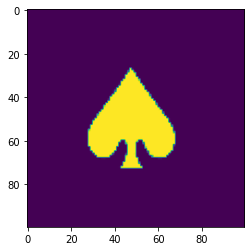

In [4]:
# You can easily load the same file here in all 4 card groups
# E.g. use cards3 for hearts

rs = lambda x: cv2.resize(x, (100, 100), cv2.INTER_CUBIC)
card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
card1 = tt(1 - card1 / card1.max())
card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
card2 = tt(1 - card2 / card2.max())
card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
card3 = tt(1 - card3 / card3.max())
card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
card4 = tt(1 - card4 / card4.max())
plt.imshow(card2)

Prepare training dataset by adding rotation, shift to the card images

In [5]:
def affine_transform(imgdata: torch.Tensor,
                     angle: torch.Tensor = None,
                     shift: torch.Tensor = None,
                     shear: torch.Tensor = None) -> torch.Tensor:                
    imgdata = imgdata[:,:,10:90, 10:90]
    if angle is not None:
        imgdata = K.geometry.rotate(imgdata, angle)
    if shear is not None:
        imgdata = K.geometry.shear(imgdata, shear)
    if shift is not None:
        imgdata = K.geometry.translate(imgdata, shift)
    return imgdata

batch_size = 1000

cards1 = card1[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards1 = cards1.to(torch.float32)
theta1 = torch.distributions.Uniform(0, 60).sample((batch_size,))
shift1 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear1 = torch.distributions.Normal(0, .00002).sample((batch_size, 2))
cards1_transformed = affine_transform(cards1, theta1, shift1, shear1)

cards2 = card2[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards2 = cards2.to(torch.float32)
theta2 = torch.distributions.Uniform(0, 60).sample((batch_size,))
shift2 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear2 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards2_transformed = affine_transform(cards2, theta2, shift2, shear2)

cards3 = card3[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards3 = cards3.to(torch.float32)
theta3 = torch.distributions.Uniform(0, 60).sample((batch_size,))
shift3 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear3 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards3_transformed = affine_transform(cards3, theta3, shift3, shear3)

cards4 = card4[None, None].repeat_interleave(batch_size, dim=0) # 10 x 1 x 64 x 64
cards4 = cards4.to(torch.float32)
theta4 = torch.distributions.Uniform(0, 60).sample((batch_size,))
shift4 = torch.distributions.Normal(0, 4).sample((batch_size, 2))
shear4 = torch.distributions.Normal(0, .002).sample((batch_size, 2))
cards4_transformed = affine_transform(cards4, theta4, shift4, shear4)

# Concatenate (this is our training set)
cards_all = torch.cat([cards1_transformed, cards2_transformed, cards3_transformed, cards4_transformed]).squeeze().float()
theta_all = torch.cat([theta1, theta2, theta3, theta4]).squeeze().float()
shift_all = torch.cat([shift1, shift2, shift3, shift4]).squeeze().float()
shear_all = torch.cat([shear1, shear2, shear3, shear4]).squeeze().float()

index_array = np.concatenate([np.zeros(cards1.shape[0]), 
                              np.zeros(cards2.shape[0])+1, 
                              np.zeros(cards3.shape[0])+2, 
                              np.zeros(cards4.shape[0])+3]
                             )

cards_all = cards_all + 0.01 * torch.randn(size=(4000,80,80))

Plot training dataset

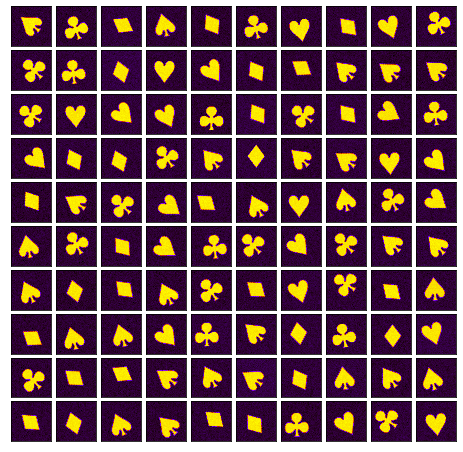

In [6]:
np.random.seed(1)
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all))
    ax.imshow(cards_all[i], cmap='gnuplot', interpolation='nearest')

Prepare training data

In [7]:
train_data = cards_all 
translation_x_, translation_y_ = shift_all[:,0].unsqueeze(1), shift_all[:,1].unsqueeze(1)
rotate_ = theta_all.unsqueeze(1)
shear_x_, shear_y_ = shear_all[:,0].unsqueeze(1), shear_all[:,1].unsqueeze(1)

In [8]:
#training steps
steps = 200

## Let us do simple VAE analysis 

In [9]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

in_dim = (80, 80)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae0 = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae0)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1949.1522
Epoch: 2 Training loss: 1212.3108
Epoch: 3 Training loss: 1201.9593
Epoch: 4 Training loss: 1195.3346
Epoch: 5 Training loss: 1169.4771
Epoch: 6 Training loss: 1150.6064
Epoch: 7 Training loss: 1129.6672
Epoch: 8 Training loss: 1094.2885
Epoch: 9 Training loss: 1022.6049
Epoch: 10 Training loss: 980.2101
Epoch: 11 Training loss: 960.4043
Epoch: 12 Training loss: 945.6564
Epoch: 13 Training loss: 931.9301
Epoch: 14 Training loss: 917.1603
Epoch: 15 Training loss: 904.0664
Epoch: 16 Training loss: 888.8677
Epoch: 17 Training loss: 873.5958
Epoch: 18 Training loss: 861.0913
Epoch: 19 Training loss: 850.5805
Epoch: 20 Training loss: 836.3774
Epoch: 21 Training loss: 822.8872
Epoch: 22 Training loss: 812.2433
Epoch: 23 Training loss: 800.7496
Epoch: 24 Training loss: 790.5512
Epoch: 25 Training loss: 783.3033
Epoch: 26 Training loss: 771.6320
Epoch: 27 Training loss: 763.7927
Epoch: 28 Training loss: 755.0356
Epoch: 29 Training loss: 749.4746
Epoch: 30 Trai

Encode the training data into the latent space:

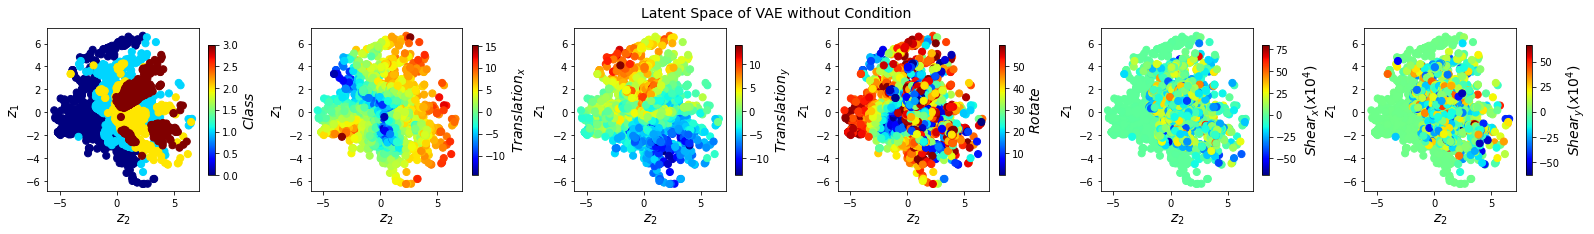

In [10]:
z_mean, z_sd = vae0.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE without Condition", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)


Plot latent variables vs ground truth

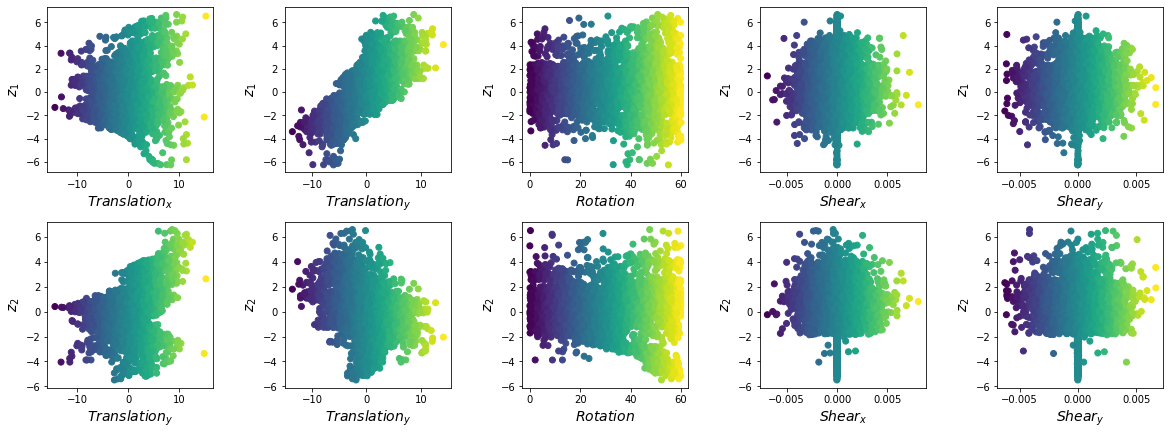

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = translation_x_);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = translation_x_)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = translation_y_);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = translation_y_);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = rotate_);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = rotate_);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = shear_x_);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = shear_x_);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = shear_y_);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = shear_y_);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

## Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about rotation as our $c$ vector.

In [12]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), rotate_, batch_size=64)

in_dim = (80, 80)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae1 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae1)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1832.7630
Epoch: 2 Training loss: 1215.1966
Epoch: 3 Training loss: 1204.9350
Epoch: 4 Training loss: 1199.6605
Epoch: 5 Training loss: 1197.6239
Epoch: 6 Training loss: 1197.6661
Epoch: 7 Training loss: 1196.3830
Epoch: 8 Training loss: 1195.0923
Epoch: 9 Training loss: 1194.3303
Epoch: 10 Training loss: 1194.4159
Epoch: 11 Training loss: 1197.7400
Epoch: 12 Training loss: 1193.9260
Epoch: 13 Training loss: 1193.2401
Epoch: 14 Training loss: 1192.2532
Epoch: 15 Training loss: 1192.9020
Epoch: 16 Training loss: 1192.1535
Epoch: 17 Training loss: 1192.4358
Epoch: 18 Training loss: 1192.8272
Epoch: 19 Training loss: 1191.6102
Epoch: 20 Training loss: 1189.4675
Epoch: 21 Training loss: 1186.2204
Epoch: 22 Training loss: 1162.3290
Epoch: 23 Training loss: 1127.1733
Epoch: 24 Training loss: 1105.1083
Epoch: 25 Training loss: 1088.4536
Epoch: 26 Training loss: 1077.0736
Epoch: 27 Training loss: 1068.3434
Epoch: 28 Training loss: 1062.2925
Epoch: 29 Training loss: 1054

Encode the training data into the latent space:

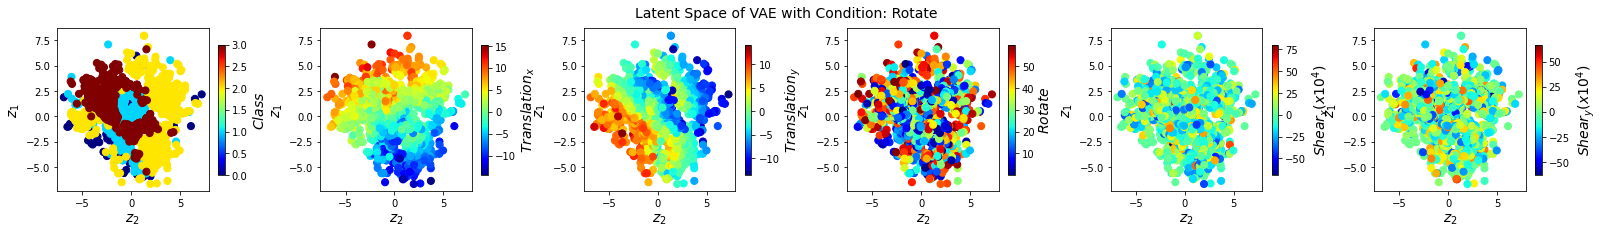

In [13]:
z_mean, z_sd = vae1.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE with Condition: Rotate", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)

- Plot the learned latent manifolds conditioned on the parameter.
- Obviously, it makes sense to check parameter range first
- But it is also cool to check how/if it extrapolates

In [14]:
print(translation_x_.min(), translation_x_.max())
print(rotate_.min(), rotate_.max())

tensor(-14.4067) tensor(15.3300)
tensor(0.0043) tensor(59.9909)


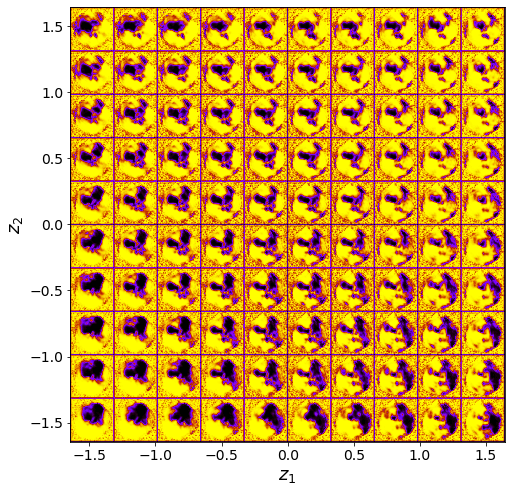

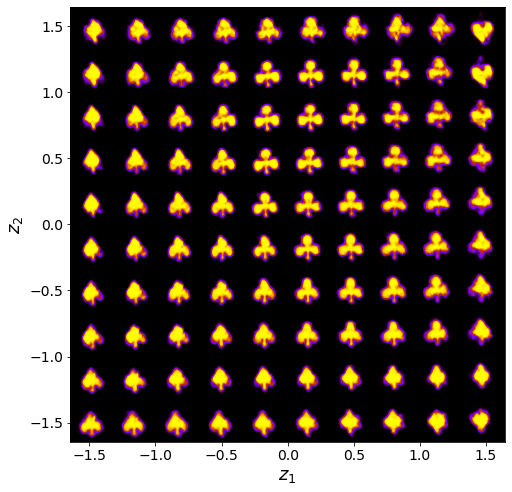

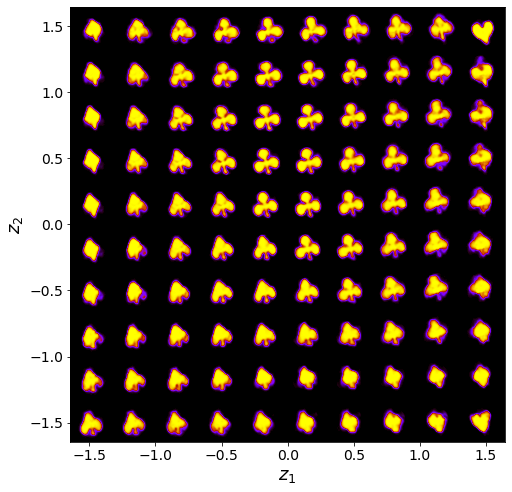

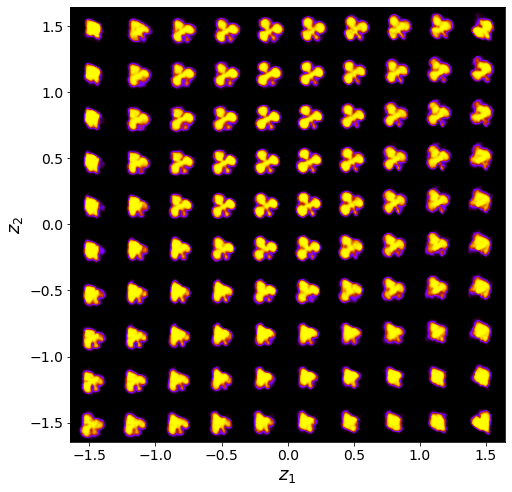

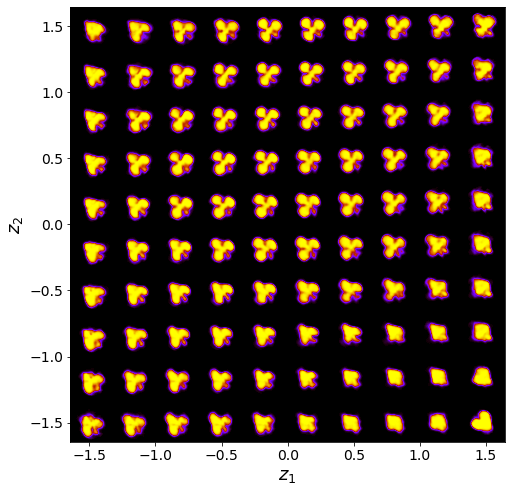

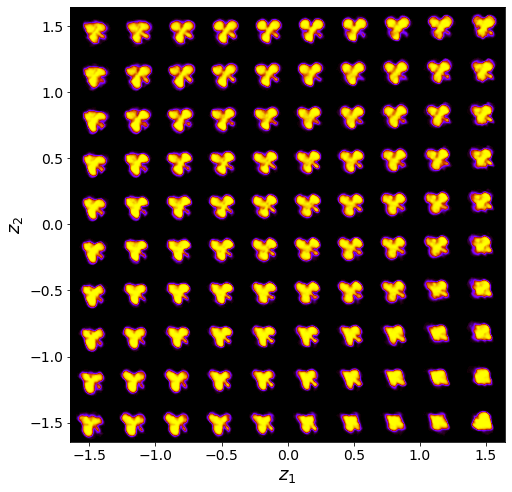

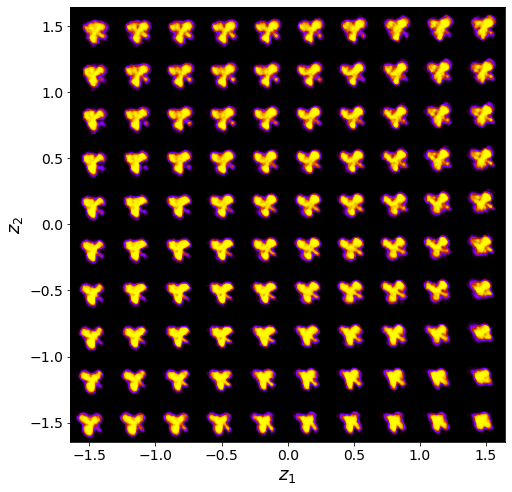

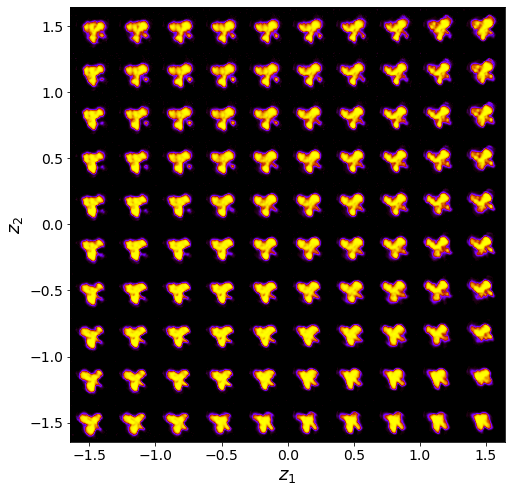

In [15]:
y_all = [-15, 0, 15, 30, 45, 60, 75, 90]
for y in y_all:
    y = torch.tensor(y).unsqueeze(0)
    vae1.manifold2d(10, y)

Plot the latent variables vs. the ground truth:

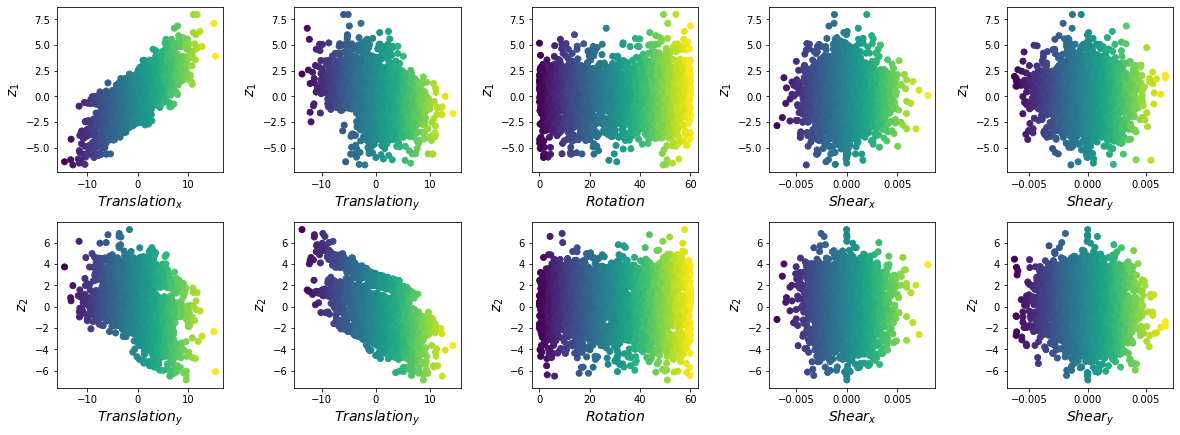

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = translation_x_);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = translation_x_)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = translation_y_);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = translation_y_);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = rotate_);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = rotate_);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = shear_x_);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = shear_x_);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = shear_y_);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = shear_y_);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

## Now let's condition on a 2-dimensional vector containing information on the translation_x and rotation.

In [17]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(
    train_data.unsqueeze(1), torch.cat([translation_x_, rotate_], -1), batch_size=64)


# Initialize VAE (we specify c_dim=2 to add extra dimensions corresponding to c-vector to the decoder)
vae2 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=2, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae2)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1841.5192
Epoch: 2 Training loss: 1210.4890
Epoch: 3 Training loss: 1181.8827
Epoch: 4 Training loss: 1151.9310
Epoch: 5 Training loss: 1126.3892
Epoch: 6 Training loss: 1097.8600
Epoch: 7 Training loss: 1079.7308
Epoch: 8 Training loss: 1070.4453
Epoch: 9 Training loss: 1061.5426
Epoch: 10 Training loss: 1054.1459
Epoch: 11 Training loss: 1027.5832
Epoch: 12 Training loss: 996.0005
Epoch: 13 Training loss: 967.0423
Epoch: 14 Training loss: 942.7548
Epoch: 15 Training loss: 912.1304
Epoch: 16 Training loss: 874.3408
Epoch: 17 Training loss: 844.1602
Epoch: 18 Training loss: 819.5055
Epoch: 19 Training loss: 798.3234
Epoch: 20 Training loss: 778.9913
Epoch: 21 Training loss: 761.2696
Epoch: 22 Training loss: 744.5167
Epoch: 23 Training loss: 728.7670
Epoch: 24 Training loss: 712.6093
Epoch: 25 Training loss: 699.1457
Epoch: 26 Training loss: 683.7416
Epoch: 27 Training loss: 669.3818
Epoch: 28 Training loss: 658.9857
Epoch: 29 Training loss: 643.5755
Epoch: 30 Tr

In [18]:
print(translation_x_.min(), translation_x_.max())
print(rotate_.min(), rotate_.max())

tensor(-14.4067) tensor(15.3300)
tensor(0.0043) tensor(59.9909)


tensor([-15]) tensor([60])


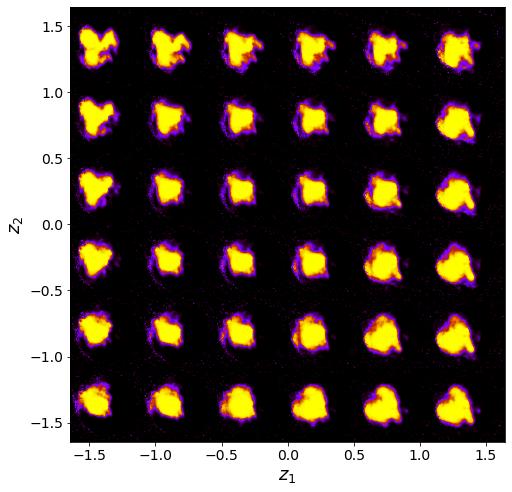

tensor([0]) tensor([60])


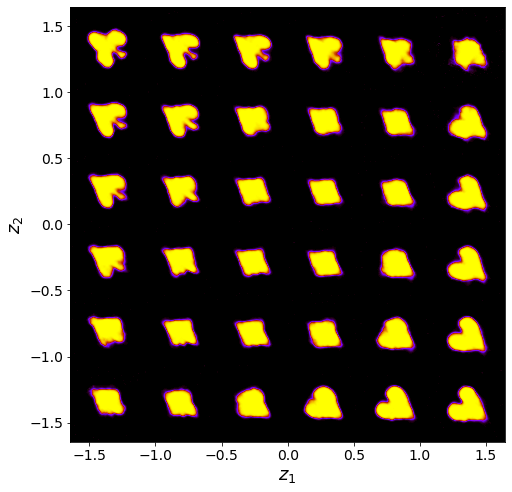

tensor([15]) tensor([60])


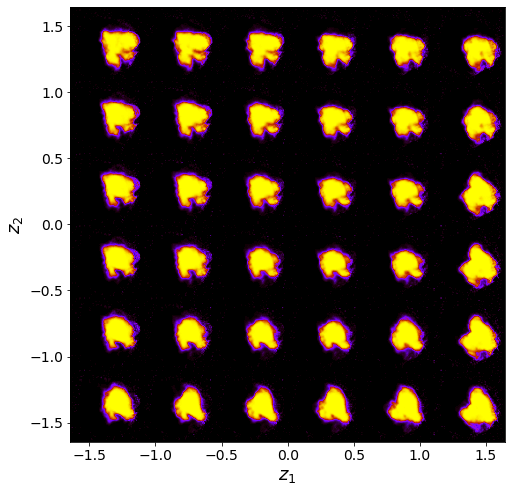

In [19]:
# Play with the evolution 

y1_all = [-15, 0, 15]
y2_all = [60]
for y in y1_all:
    y1 = torch.tensor(y).unsqueeze(0)
    y2 = torch.tensor(y2_all)
    print(y1, y2)
    y = torch.cat([y1, y2], -1).unsqueeze(0)
    vae2.manifold2d(6, y)

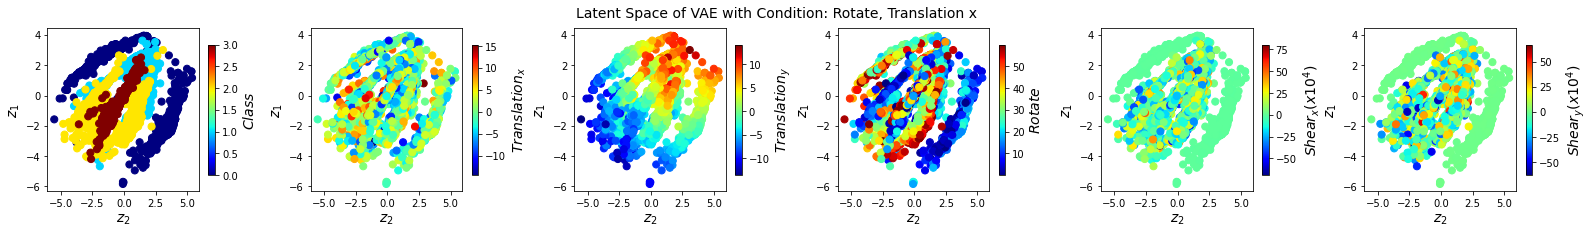

In [20]:
### Encode the training data into the latent space:###

z_mean, z_sd = vae2.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE with Condition: Rotate, Translation x", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)

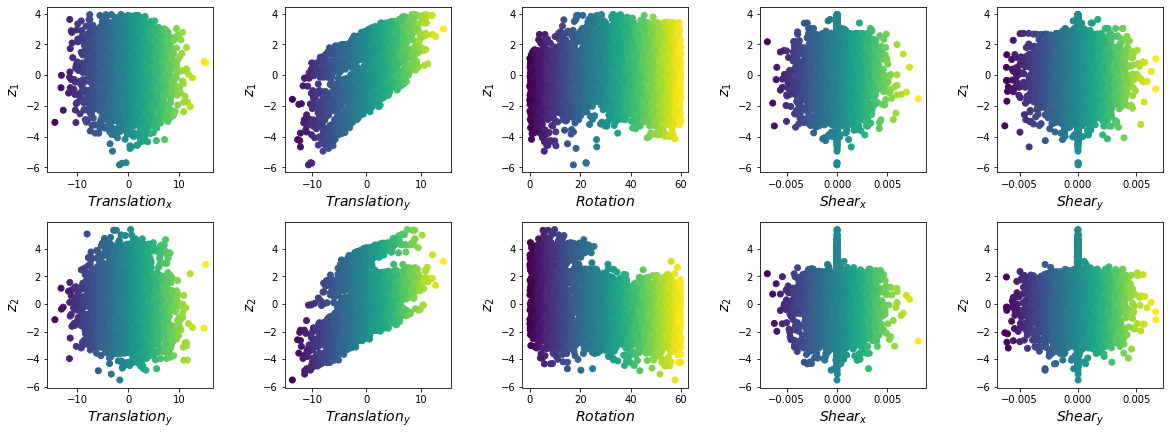

In [21]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = translation_x_);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = translation_x_)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = translation_y_);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = translation_y_);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = rotate_);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = rotate_);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = shear_x_);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = shear_x_);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = shear_y_);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = shear_y_);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

## Now let's condition on a 3-dimensional vector containing information on the translation_x, translation_y, rotation.

In [22]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(
    train_data.unsqueeze(1), torch.cat([translation_x_, translation_y_, rotate_], -1), batch_size=64)


# Initialize VAE (we specify c_dim=2 to add extra dimensions corresponding to c-vector to the decoder)
vae3 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=3, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae3)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1851.5321
Epoch: 2 Training loss: 1210.4405
Epoch: 3 Training loss: 1168.0663
Epoch: 4 Training loss: 1095.8100
Epoch: 5 Training loss: 1026.1470
Epoch: 6 Training loss: 978.7482
Epoch: 7 Training loss: 945.4083
Epoch: 8 Training loss: 917.9368
Epoch: 9 Training loss: 888.1716
Epoch: 10 Training loss: 831.7659
Epoch: 11 Training loss: 786.2510
Epoch: 12 Training loss: 757.2764
Epoch: 13 Training loss: 733.6224
Epoch: 14 Training loss: 710.6925
Epoch: 15 Training loss: 688.8527
Epoch: 16 Training loss: 666.9999
Epoch: 17 Training loss: 644.2646
Epoch: 18 Training loss: 622.6555
Epoch: 19 Training loss: 601.8549
Epoch: 20 Training loss: 582.1169
Epoch: 21 Training loss: 565.9273
Epoch: 22 Training loss: 549.9396
Epoch: 23 Training loss: 535.8780
Epoch: 24 Training loss: 522.1302
Epoch: 25 Training loss: 509.5850
Epoch: 26 Training loss: 497.8793
Epoch: 27 Training loss: 487.4087
Epoch: 28 Training loss: 477.1297
Epoch: 29 Training loss: 467.8713
Epoch: 30 Training

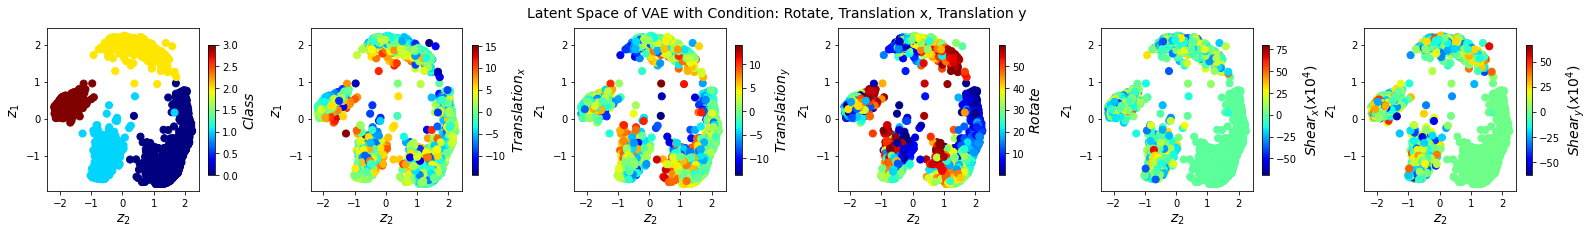

In [23]:
### Encode the training data into the latent space:###

z_mean, z_sd = vae3.encode(train_data)


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE with Condition: Rotate, Translation x, Translation y", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)

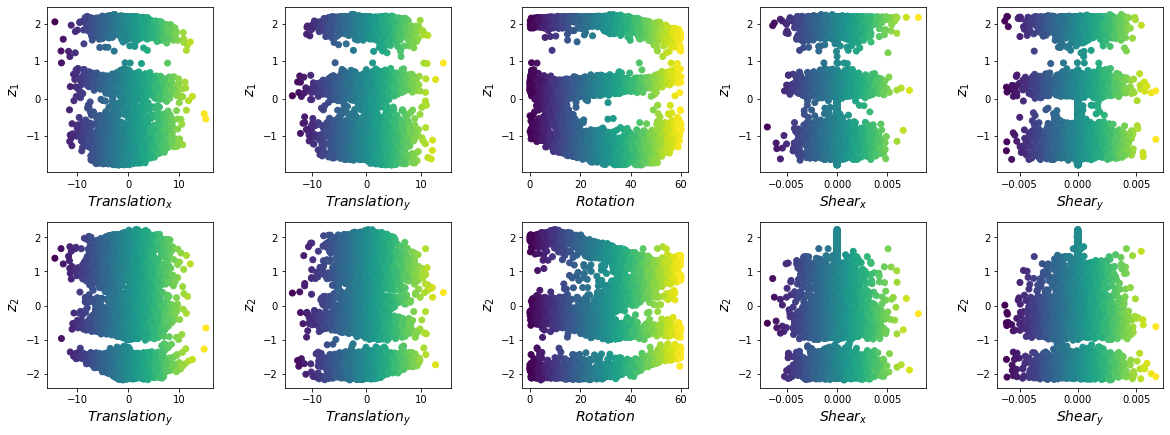

In [24]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = translation_x_);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = translation_x_)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = translation_y_);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = translation_y_);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = rotate_);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = rotate_);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = shear_x_);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = shear_x_);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = shear_y_);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = shear_y_);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);

## Now let's condition on a 5-dimensional vector containing information on the translation_x, translation_y, rotation, sheer_x, sheer_y.

In [25]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(
    train_data.unsqueeze(1), torch.cat([translation_x_, translation_y_, rotate_, shear_x_, shear_y_], -1), batch_size=64)


# Initialize VAE (we specify c_dim=2 to add extra dimensions corresponding to c-vector to the decoder)
vae5 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=5, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae5)

# Train for n epochs:
for e in range(steps):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 1833.7318
Epoch: 2 Training loss: 1214.9995
Epoch: 3 Training loss: 1202.1830
Epoch: 4 Training loss: 1197.8257
Epoch: 5 Training loss: 1184.1096
Epoch: 6 Training loss: 1098.6857
Epoch: 7 Training loss: 996.6419
Epoch: 8 Training loss: 945.8147
Epoch: 9 Training loss: 914.6628
Epoch: 10 Training loss: 875.6740
Epoch: 11 Training loss: 838.8390
Epoch: 12 Training loss: 812.1815
Epoch: 13 Training loss: 783.0497
Epoch: 14 Training loss: 745.9355
Epoch: 15 Training loss: 707.7389
Epoch: 16 Training loss: 677.5791
Epoch: 17 Training loss: 649.1268
Epoch: 18 Training loss: 623.6513
Epoch: 19 Training loss: 600.5545
Epoch: 20 Training loss: 579.1518
Epoch: 21 Training loss: 560.7585
Epoch: 22 Training loss: 544.5061
Epoch: 23 Training loss: 530.1172
Epoch: 24 Training loss: 516.7637
Epoch: 25 Training loss: 504.4668
Epoch: 26 Training loss: 494.4897
Epoch: 27 Training loss: 482.4522
Epoch: 28 Training loss: 471.0410
Epoch: 29 Training loss: 460.9562
Epoch: 30 Trainin

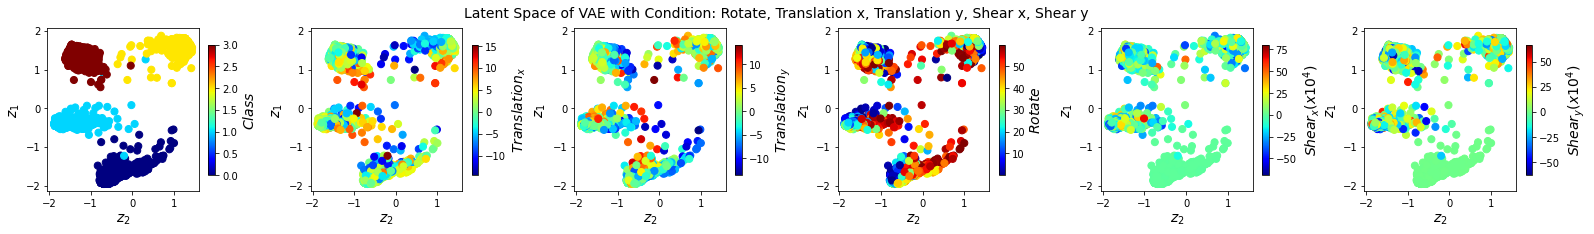

In [26]:
### Encode the training data into the latent space:###

z_mean, z_sd = vae5.encode(train_data)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(27, 3))
fig.subplots_adjust(wspace = 0.39)
fig.suptitle("Latent Space of VAE with Condition: Rotate, Translation x, Translation y, Shear x, Shear y", fontsize=14)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = index_array, cmap = 'jet') 
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$Class$", fontsize=14)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_x_, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$Translation_x$", fontsize=14)

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = translation_y_, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$Translation_y$", fontsize=14)

im4 = ax4.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = rotate_, cmap = 'jet')
ax4.set_xlabel("$z_2$", fontsize=14)
ax4.set_ylabel("$z_1$", fontsize=14)
cbar4 = fig.colorbar(im4, ax=ax4, shrink=.8)
cbar4.set_label("$Rotate$", fontsize=14)

im5 = ax5.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_x_*10000, cmap = 'jet')
ax5.set_xlabel("$z_2$", fontsize=14)
ax5.set_ylabel("$z_1$", fontsize=14)
cbar5 = fig.colorbar(im5, ax=ax5, shrink=.8)
cbar5.set_label("$Shear_x  (x10^4)$", fontsize=14)

im6 = ax6.scatter(z_mean[:, -1], z_mean[:, -2], s=50, c = shear_y_*10000, cmap = 'jet')
ax6.set_xlabel("$z_2$", fontsize=14)
ax6.set_ylabel("$z_1$", fontsize=14)
cbar6 = fig.colorbar(im6, ax=ax6, shrink=.8)
cbar6.set_label("$Shear_y  (x10^4)$", fontsize=14)

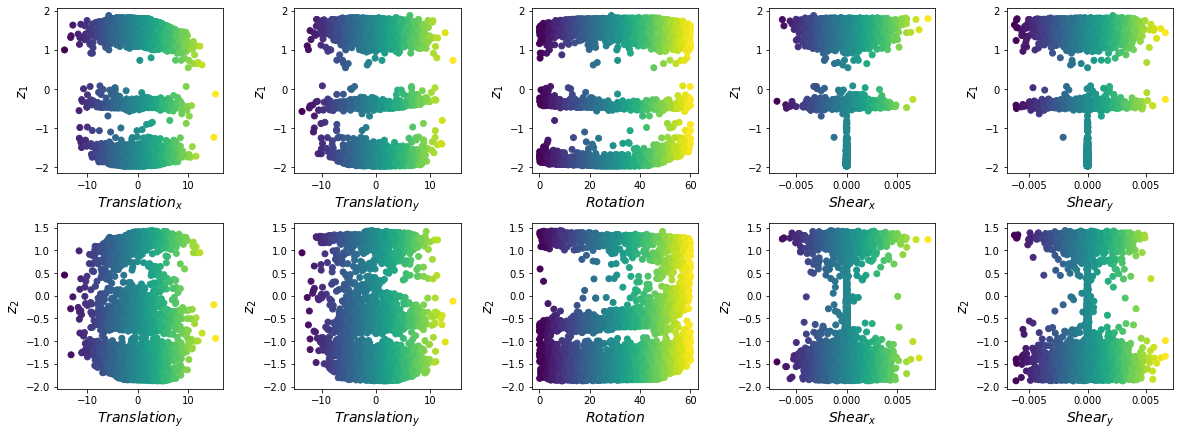

In [27]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
fig.subplots_adjust(wspace = 0.43, hspace = 0.3)

ax[0, 0].scatter(translation_x_, z_mean[:, -2], c = translation_x_);
ax[0, 0].set_xlabel("$Translation_x$", fontsize=14);
ax[0, 0].set_ylabel("$z_1$", fontsize=14);
ax[1, 0].scatter(translation_x_, z_mean[:, -1], c = translation_x_)
ax[1, 0].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 0].set_ylabel("$z_2$", fontsize=14);

ax[0, 1].scatter(translation_y_, z_mean[:, -2], c = translation_y_);
ax[0, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[0, 1].set_ylabel("$z_1$", fontsize=14);
ax[1, 1].scatter(translation_y_, z_mean[:, -1], c = translation_y_);
ax[1, 1].set_xlabel("$Translation_y$", fontsize=14);
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(rotate_, z_mean[:, -2], c = rotate_);
ax[0, 2].set_xlabel("$Rotation$", fontsize=14);
ax[0, 2].set_ylabel("$z_1$", fontsize=14);
ax[1, 2].scatter(rotate_, z_mean[:, -1], c = rotate_);
ax[1, 2].set_xlabel("$Rotation$", fontsize=14);
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

ax[0, 3].scatter(shear_x_, z_mean[:, -2], c = shear_x_);
ax[0, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[0, 3].set_ylabel("$z_1$", fontsize=14);
ax[1, 3].scatter(shear_x_, z_mean[:, -1], c = shear_x_);
ax[1, 3].set_xlabel("$Shear_x$", fontsize=14);
ax[1, 3].set_ylabel("$z_2$", fontsize=14);

ax[0, 4].scatter(shear_y_, z_mean[:, -2], c = shear_y_);
ax[0, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[0, 4].set_ylabel("$z_1$", fontsize=14);
ax[1, 4].scatter(shear_y_, z_mean[:, -1], c = shear_y_);
ax[1, 4].set_xlabel("$Shear_y$", fontsize=14);
ax[1, 4].set_ylabel("$z_2$", fontsize=14);